In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:10.778265. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:11.316134. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


#### Load data 

In [4]:
data = pd.read_csv("../data/train.csv", na_values=[-1, -1.0], index_col="id")

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:11.814053. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
X, y = data.loc[:, data.columns != "target"], data.target

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:16.179292. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


#### Preprocess 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

/usr/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:16.289046. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


#### Balance

In [7]:
%%time
resampler = RandomUnderSampler()
indexes = X_train.index.values.reshape(-1, 1)
index_res, y_res = resampler.fit_sample(indexes, y_train)

CPU times: user 200 ms, sys: 20 ms, total: 220 ms
Wall time: 219 ms


/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:16.916018. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


#### With NaNs 

In [8]:
X_res = X_train.loc[index_res.flatten(), :]

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-13 14:36:17.143314. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
model = XGBClassifier()
model.fit(X_res, y_res)
y_pred = model.predict_proba(X_test)[:, 1]

nan_gini = gini_normalized(y_test, y_pred)
print(nan_gini)

0.270096026758


#### Fill with Mean 

In [10]:
X_mean = X_res.fillna(X_res.mean())

In [11]:
model = XGBClassifier()
model.fit(X_mean, y_res)
y_pred = model.predict_proba(X_test.fillna(X_test.mean()))[:, 1]

mean_gini = gini_normalized(y_test, y_pred)
print(mean_gini)

0.271818157288


#### Fill with Median

In [12]:
X_median = X_res.fillna(X_res.median())

In [13]:
model = XGBClassifier()
model.fit(X_median, y_res)
y_pred = model.predict_proba(X_test.fillna(X_test.median()))[:, 1]

median_gini = gini_normalized(y_test, y_pred)
print(median_gini)

0.270003440503


#### Results 

(0, 1)

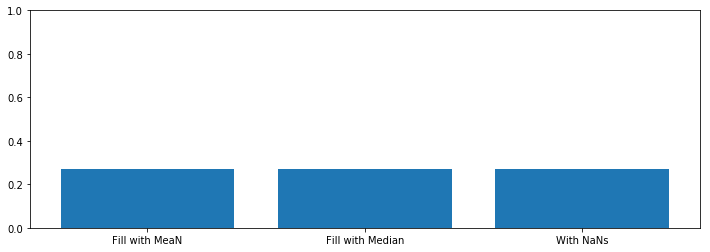

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(["With NaNs", "Fill with MeaN", "Fill with Median"], [nan_gini, mean_gini, median_gini])
ax.set_ylim(0, 1)